# Estimador de precios de inmuebles en la ciudad de San Juan, Argentina.

## 1. Inicialización: librerías, configuraciones y variables globales

### Importación de Librerías

In [48]:
!pip install optuna
import optuna

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 2.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 10.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install joblib
!pip install lightgbm
!pip install scikit-learn
!pip install nltk
!pip install transformers
!pip install pandas
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install tensorflow
!pip install torch
!pip install tf-keras
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 7.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
import requests
from bs4 import BeautifulSoup

import sqlite3
import re
import unicodedata
import os
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import joblib

import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder,BigramAssocMeasures
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('all')

from transformers import pipeline

import spacy
nlp = spacy.load('es_core_news_sm')
import optuna

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nespina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nespina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/nespina/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/nespina/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/nespina/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/nespina/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is alread

## 2. Importación de Base de datos

### Buscar la base de datos

In [36]:

conn = sqlite3.connect('inmuebles_normalizada.db')
df_all = pd.read_sql_query("SELECT * FROM inmuebles", conn)
conn.close()

In [37]:
def limpiar_texto(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Reemplazar tildes
    text = text.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u').replace('Á', 'A').replace('É', 'E').replace('Í', 'I').replace('Ó', 'O').replace('Ú', 'U')
    # Eliminar números y caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Eliminar espacios en blanco adicionales
    text = ' '.join(text.split())
    # Tokenizar el texto
    tokens = word_tokenize(text, language='spanish')
    # Eliminar stop words
    stop_words = set(stopwords.words('spanish'))
    tokens = [word for word in tokens if not word in stop_words]
    # Lematizar las palabras
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Unir los tokens de nuevo en una cadena
    processed_text = ' '.join(tokens)
    return processed_text

df_all['comentarios'] = df_all['comentarios'].apply(limpiar_texto)

## Realizamos un análisis de sentimientos del texto "comentarios"

In [38]:

# Cargar el modelo de análisis de sentimientos
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Función para analizar el sentimiento de un texto
def analyze_sentiment(text):
  #Se trunca el texto a un máximo de 512 tokens para que se ajuste al modelo BERT.
  result = sentiment_pipeline(text[:512])
  return result[0]['label'], result[0]['score']

# Aplicar la función al DataFrame
df_all[['sentiment_label', 'sentiment_score']] = df_all['comentarios'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Mapear las etiquetas de sentimiento a valores numéricos
sentiment_mapping = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}
df_all['des_sentimiento'] = df_all['sentiment_label'].map(sentiment_mapping)

Device set to use cpu


### Realizamos una Clasificación de texto de la variable Des

In [39]:
# Cargar el pipeline para clasificación de texto con BERT
classifier = pipeline('text-classification', model='dccuchile/bert-base-spanish-wwm-uncased')

# Función para clasificar el texto
def classify_text(text):
  result = classifier(text[:775])
  return result[0]['label'], result[0]['score']

# Aplicar la función al DataFrame
df_all[['classification_label', 'classification_score']] = df_all['comentarios'].apply(lambda x: pd.Series(classify_text(x)))
df_all['des_clasificacion'] = df_all['classification_label'].map({'LABEL_0': False, 'LABEL_1': True})


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


In [40]:
df_all.head()

,precio,publicacion,visitas,anuncio_id,superficie_total,superficie_cubierta,apto_credito,en_barrio_privado,latitude,longitude,image_blob,antiguedad_A estrenar,antiguedad_En construcción,antiguedad_Mas de 40 años,antiguedad_Menos de 10 años,antiguedad_Menos de 20 años,antiguedad_Menos de 30 años,antiguedad_Menos de 40 años,antiguedad_Menos de 5 años,departamento_25 de Mayo,departamento_9 de Julio,departamento_Albardon,departamento_Angaco,departamento_Calingasta,departamento_Capital,departamento_Caucete,departamento_Chimbas,departamento_Fuera de San Juan,departamento_Iglesia,departamento_Jachal,departamento_Pocito,departamento_Rawson,departamento_Rivadavia,departamento_San Martin,departamento_Santa Lucia,departamento_Sarmiento,departamento_Ullum,departamento_Valle Fertil,departamento_Zonda,banos_1,banos_2,banos_3,banos_4,banos_5 o mas,ambientes_1,ambientes_2,ambientes_3,ambientes_4,ambientes_5 o mas,garages_1,garages_2,garages_3,garages_3 o mas,dormitorios_1,dormitorios_2,dormitorios_3,dormitorios_4,dormitorios_5 o mas,dormitorios_Monoambiente,orientacion_Este,orientacion_Norte,orientacion_Oeste,orientacion_Sur,comentarios,sentiment_label,sentiment_score,des_sentimiento,classification_label,classification_score,des_clasificacion
0,84000.0,2025-03-25 00:00:00,1834,2437637,285.0,200.0,0,0,-31.538912,-68.491217,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,casa deshabitada cochera verde rejas hierro ba...,3 stars,0.246411,3,LABEL_1,0.540352,True
1,194000.0,2025-03-25 00:00:00,222,2444538,265.0,110.0,0,0,-31.543174,-68.530584,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,apta credito hipotecario escritura titular lis...,1 star,0.475952,1,LABEL_1,0.557092,True
2,NaN,2025-03-25 00:00:00,503,2439764,1500.0,NaN,0,1,-31.537213,-68.525290,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,entrega equipado porcelanato xbajo mesada alac...,5 stars,0.446088,5,LABEL_0,0.507304,False
3,210000.0,2025-03-25 00:00:00,6034,2147669,370.0,180.0,0,1,-31.537213,-68.525290,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,hermosa casa construccion planta mtrs cubierto...,5 stars,0.649279,5,LABEL_1,0.596436,True
4,150000.0,2025-03-25 00:00:00,148,2434838,247.0,171.0,0,0,-31.537213,-68.525290,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,trata propiedad optimo ubicada calle jujuy sur...,5 stars,0.407502,5,LABEL_1,0.564516,True


In [41]:
# Eliminar las columnas especificadas
df_all = df_all.drop(columns=[
    'sentiment_label','sentiment_score', 'classification_score', 'classification_label'
])

# Mostrar las primeras filas del DataFrame para verificar el resultado
df_all.head()


,precio,publicacion,visitas,anuncio_id,superficie_total,superficie_cubierta,apto_credito,en_barrio_privado,latitude,longitude,image_blob,antiguedad_A estrenar,antiguedad_En construcción,antiguedad_Mas de 40 años,antiguedad_Menos de 10 años,antiguedad_Menos de 20 años,antiguedad_Menos de 30 años,antiguedad_Menos de 40 años,antiguedad_Menos de 5 años,departamento_25 de Mayo,departamento_9 de Julio,departamento_Albardon,departamento_Angaco,departamento_Calingasta,departamento_Capital,departamento_Caucete,departamento_Chimbas,departamento_Fuera de San Juan,departamento_Iglesia,departamento_Jachal,departamento_Pocito,departamento_Rawson,departamento_Rivadavia,departamento_San Martin,departamento_Santa Lucia,departamento_Sarmiento,departamento_Ullum,departamento_Valle Fertil,departamento_Zonda,banos_1,banos_2,banos_3,banos_4,banos_5 o mas,ambientes_1,ambientes_2,ambientes_3,ambientes_4,ambientes_5 o mas,garages_1,garages_2,garages_3,garages_3 o mas,dormitorios_1,dormitorios_2,dormitorios_3,dormitorios_4,dormitorios_5 o mas,dormitorios_Monoambiente,orientacion_Este,orientacion_Norte,orientacion_Oeste,orientacion_Sur,comentarios,des_sentimiento,des_clasificacion
0,84000.0,2025-03-25 00:00:00,1834,2437637,285.0,200.0,0,0,-31.538912,-68.491217,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,casa deshabitada cochera verde rejas hierro ba...,3,True
1,194000.0,2025-03-25 00:00:00,222,2444538,265.0,110.0,0,0,-31.543174,-68.530584,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,apta credito hipotecario escritura titular lis...,1,True
2,NaN,2025-03-25 00:00:00,503,2439764,1500.0,NaN,0,1,-31.537213,-68.525290,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,entrega equipado porcelanato xbajo mesada alac...,5,False
3,210000.0,2025-03-25 00:00:00,6034,2147669,370.0,180.0,0,1,-31.537213,-68.525290,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,hermosa casa construccion planta mtrs cubierto...,5,True
4,150000.0,2025-03-25 00:00:00,148,2434838,247.0,171.0,0,0,-31.537213,-68.525290,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,trata propiedad optimo ubicada calle jujuy sur...,5,True


In [42]:
df_backup = df_all.copy()

In [51]:
df_all = df_backup.copy()

In [ ]:
# Inicializar el vectorizador TF-IDF

# Vectorización con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 1), tokenizer=word_tokenize)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_all['comentarios'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{col}' for col in tfidf_feature_names])

# Convertir la matriz TF-IDF a un DataFrame de pandas
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenar el DataFrame de TF-IDF con el DataFrame original
df_all = pd.concat([df_all, tfidf_df], axis=1)

# Mostrar las primeras filas del DataFrame
df_all.shape


(3158, 566)

In [53]:
df_all['precio'].head()

0     84000.0
1    194000.0
2         NaN
3    210000.0
4    150000.0
Name: precio, dtype: float64

In [54]:

# Eliminar filas con valores nulos en la columna 'precio'
df_all = df_all.dropna(subset=['precio'])

# Definir características (features) y variable objetivo (target)
X = df_all.drop(['precio','publicacion', 'image_blob', 'comentarios'], axis=1)
y = df_all['precio']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y_train)
print(y_test)
# Crear un dataset de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Definir los parámetros para el modelo
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.9967880717646387,
    'num_leaves': 31,
    'max_depth': 10,
    'subsample': 0.7797370559774017,
    'learning_rate': 0.0977729735815334,
    'feature_fraction': 1.0,
    'n_estimators': 161
}

# Entrenar el modelo
model = lgb.train(params,
                  train_data,
                  num_boost_round=100,
                  valid_sets=[test_data],
                  callbacks=[lgb.early_stopping(stopping_rounds=10)])  # Usar early_stopping callback

# Predecir el subconjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"RMSE: {rmse}")


952      35000.0
933     110000.0
1671    250000.0
1848     55000.0
2129    200000.0
          ...   
1784    110000.0
2055    160000.0
1318    200000.0
2318    600000.0
1776     90000.0
Name: precio, Length: 1406, dtype: float64
2510     65000.000000
900      80000.000000
694     180000.000000
2224     80000.000000
759        244.405407
            ...      
1030    145000.000000
2128    180000.000000
1291     50000.000000
2597    180000.000000
1315     50000.000000
Name: precio, Length: 603, dtype: float64
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_w

In [55]:


# Definir la función objetivo para la optimización
def objective(trial):
    # Definir los hiperparámetros a optimizar
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200)
    }

    # Entrenar el modelo con los hiperparámetros actuales
    model = lgb.train(params, train_data, valid_sets=[test_data])
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular el RMSE
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    return rmse

# Crear un estudio para la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
model = lgb.train(best_params, train_data, num_boost_round=100, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

# Predecir y evaluar el modelo optimizado
y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"RMSE después de la optimización bayesiana: {rmse}")

[I 2025-04-08 18:38:27,427] A new study created in memory with name: no-name-beb21416-3fef-4bef-a5a6-dd012ae0bac7


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7004027159098939, colsample_bytree=0.7581170599865243 will be ignored. Current value: feature_fraction=0.7004027159098939
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7004027159098939, colsample_bytree=0.7581170599865243 will be ignored. Current value: feature_fraction=0.7004027159098939
[LightGBM] [Warning] feature_fraction is set=0.7004027159098939, colsample_bytree=0.7581170599865243 will be ignored. Current value: feature_fraction=0.7004027159098939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[I 2025-04-08 18:38:27,690] Trial 0 finished with value: 1830184.293272104 and parameters: {'colsample_bytree': 0.7581170599865243, 'num_leaves': 28, 'max_depth': 13, 'subsample': 0.7020052134309609, 'learning_rate': 0.07460374699688184, 'feature_fraction': 0.7004027159098939, 'n_estimators': 69}. Best is trial 0 with value: 1830184.293272104.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8350595976319379, colsample_bytree=0.9289064182497263 will be ignored. Current value: feature_fraction=0.8350595976319379
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8350595976319379, colsample_bytree=0.9289064182497263 will be ignored. Current value: feature_fraction=0.8350595976319379
[LightGBM] [Warning] feature_fraction is set=0.8350595976319379, colsample_bytree=0.9289064182497263 will be ignored. Current value: feature_fraction=0.8350595976319379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to

[I 2025-04-08 18:38:28,062] Trial 1 finished with value: 1829682.2565330775 and parameters: {'colsample_bytree': 0.9289064182497263, 'num_leaves': 22, 'max_depth': 9, 'subsample': 0.6797842908240683, 'learning_rate': 0.19267490485125607, 'feature_fraction': 0.8350595976319379, 'n_estimators': 151}. Best is trial 1 with value: 1829682.2565330775.
[I 2025-04-08 18:38:28,178] Trial 2 finished with value: 1831147.4974522537 and parameters: {'colsample_bytree': 0.7347378900253543, 'num_leaves': 43, 'max_depth': 5, 'subsample': 0.6005684735961705, 'learning_rate': 0.14505197388879357, 'feature_fraction': 0.8160183302743922, 'n_estimators': 68}. Best is trial 1 with value: 1829682.2565330775.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8160183302743922, colsample_bytree=0.7347378900253543 will be ignored. Current value: feature_fraction=0.8160183302743922
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8160183302743922, colsample_bytree=0.7347378900253543 will be ignored. Current value: feature_fraction=0.8160183302743922
[LightGBM] [Warning] feature_fraction is set=0.8160183302743922, colsample_bytree=0.7347378900253543 will be ignored. Current value: feature_fraction=0.8160183302743922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[I 2025-04-08 18:38:28,518] Trial 3 finished with value: 1830056.4567733065 and parameters: {'colsample_bytree': 0.7589315964900618, 'num_leaves': 31, 'max_depth': 13, 'subsample': 0.5599414540403227, 'learning_rate': 0.029510487996359705, 'feature_fraction': 0.5994868876996973, 'n_estimators': 81}. Best is trial 1 with value: 1829682.2565330775.
[I 2025-04-08 18:38:28,716] Trial 4 finished with value: 1830618.7006402053 and parameters: {'colsample_bytree': 0.5052111126001166, 'num_leaves': 26, 'max_depth': 8, 'subsample': 0.8717732115924121, 'learning_rate': 0.03911966584364263, 'feature_fraction': 0.7000466583482269, 'n_estimators': 58}. Best is trial 1 with value: 1829682.2565330775.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7000466583482269, colsample_bytree=0.5052111126001166 will be ignored. Current value: feature_fraction=0.7000466583482269
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7000466583482269, colsample_bytree=0.5052111126001166 will be ignored. Current value: feature_fraction=0.7000466583482269
[LightGBM] [Warning] feature_fraction is set=0.7000466583482269, colsample_bytree=0.5052111126001166 will be ignored. Current value: feature_fraction=0.7000466583482269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[I 2025-04-08 18:38:29,257] Trial 5 finished with value: 1830490.172508083 and parameters: {'colsample_bytree': 0.9261160077001878, 'num_leaves': 37, 'max_depth': 15, 'subsample': 0.7366390784645409, 'learning_rate': 0.07096667799216737, 'feature_fraction': 0.8147140835773321, 'n_estimators': 132}. Best is trial 1 with value: 1829682.2565330775.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7697662262975609, colsample_bytree=0.595430632765968 will be ignored. Current value: feature_fraction=0.7697662262975609
[LightGBM] [Warnin

[I 2025-04-08 18:38:29,637] Trial 6 finished with value: 1829383.7987231023 and parameters: {'colsample_bytree': 0.595430632765968, 'num_leaves': 49, 'max_depth': 13, 'subsample': 0.5988940481020958, 'learning_rate': 0.1280316290189222, 'feature_fraction': 0.7697662262975609, 'n_estimators': 88}. Best is trial 6 with value: 1829383.7987231023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5378580571057164, colsample_bytree=0.9737664527137009 will be ignored. Current value: feature_fraction=0.5378580571057164
[LightGBM] [Warni

[I 2025-04-08 18:38:29,896] Trial 7 finished with value: 1829859.0775732778 and parameters: {'colsample_bytree': 0.9737664527137009, 'num_leaves': 36, 'max_depth': 6, 'subsample': 0.9694017704316767, 'learning_rate': 0.09958878963438995, 'feature_fraction': 0.5378580571057164, 'n_estimators': 128}. Best is trial 6 with value: 1829383.7987231023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:30,258] Trial 8 finished with value: 1829937.3325093787 and parameters: {'colsample_bytree': 0.7831829330099995, 'num_leaves': 22, 'max_depth': 7, 'subsample': 0.5041566260347274, 'learning_rate': 0.1332968091204432, 'feature_fraction': 0.6224763085020919, 'n_estimators': 122}. Best is trial 6 with value: 1829383.7987231023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fractio

[I 2025-04-08 18:38:30,775] Trial 9 finished with value: 1830044.1223891354 and parameters: {'colsample_bytree': 0.8948390595748101, 'num_leaves': 49, 'max_depth': 10, 'subsample': 0.7066300823664377, 'learning_rate': 0.07332912060452997, 'feature_fraction': 0.7531496072217816, 'n_estimators': 137}. Best is trial 6 with value: 1829383.7987231023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:31,609] Trial 10 finished with value: 1829781.331428836 and parameters: {'colsample_bytree': 0.5363558187534632, 'num_leaves': 49, 'max_depth': 12, 'subsample': 0.8374021046546144, 'learning_rate': 0.1955972158161362, 'feature_fraction': 0.9991362032219308, 'n_estimators': 199}. Best is trial 6 with value: 1829383.7987231023.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:32,210] Trial 11 finished with value: 1828855.2935689576 and parameters: {'colsample_bytree': 0.6248243848812951, 'num_leaves': 42, 'max_depth': 10, 'subsample': 0.6259613687610684, 'learning_rate': 0.19977243542808587, 'feature_fraction': 0.9283808999652184, 'n_estimators': 169}. Best is trial 11 with value: 1828855.2935689576.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:32,934] Trial 12 finished with value: 1829906.8417083367 and parameters: {'colsample_bytree': 0.6130947398726124, 'num_leaves': 43, 'max_depth': 11, 'subsample': 0.6176989269532791, 'learning_rate': 0.15840788351684976, 'feature_fraction': 0.9631448435463443, 'n_estimators': 182}. Best is trial 11 with value: 1828855.2935689576.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.910604114397662, colsample_bytree=0.6305895968327847 will be ignored. Current value: feature_fraction=0.910604114397662
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.910604114397662, colsample_bytree=0.6305895968327847 will 

[I 2025-04-08 18:38:33,450] Trial 13 finished with value: 1828783.378436764 and parameters: {'colsample_bytree': 0.6305895968327847, 'num_leaves': 43, 'max_depth': 15, 'subsample': 0.6410880468544727, 'learning_rate': 0.16976336796964803, 'feature_fraction': 0.910604114397662, 'n_estimators': 98}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:33,947] Trial 14 finished with value: 1829573.599381108 and parameters: {'colsample_bytree': 0.6626596620684936, 'num_leaves': 41, 'max_depth': 15, 'subsample': 0.7979553511416544, 'learning_rate': 0.1704537933019489, 'feature_fraction': 0.9153066698692037, 'n_estimators': 100}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:34,613] Trial 15 finished with value: 1829540.1341947734 and parameters: {'colsample_bytree': 0.6685739288687367, 'num_leaves': 40, 'max_depth': 10, 'subsample': 0.6434069770522793, 'learning_rate': 0.17873432458036162, 'feature_fraction': 0.8965615307826851, 'n_estimators': 163}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:35,089] Trial 16 finished with value: 1829175.489351757 and parameters: {'colsample_bytree': 0.5987698527679974, 'num_leaves': 45, 'max_depth': 11, 'subsample': 0.5054399374422608, 'learning_rate': 0.1990895669789521, 'feature_fraction': 0.893915507512204, 'n_estimators': 110}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9309755026894373, colsample_bytree=0.6907018660710905 will be ignored. Current value: feature_fraction=0.9309755026894373
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.9309755026894373, colsample_bytree=0.6907018660710905 will be ignored. Current value: feature_fraction=0.9309755026894373
[LightGBM

[I 2025-04-08 18:38:35,576] Trial 17 finished with value: 1830655.4118918192 and parameters: {'colsample_bytree': 0.6907018660710905, 'num_leaves': 39, 'max_depth': 8, 'subsample': 0.7751975746362973, 'learning_rate': 0.11149370005072085, 'feature_fraction': 0.9309755026894373, 'n_estimators': 166}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:36,434] Trial 18 finished with value: 1829450.5880981628 and parameters: {'colsample_bytree': 0.8325465926478683, 'num_leaves': 34, 'max_depth': 14, 'subsample': 0.6621071314422733, 'learning_rate': 0.16829190256926027, 'feature_fraction': 0.8561683763756087, 'n_estimators': 200}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feat

[I 2025-04-08 18:38:36,870] Trial 19 finished with value: 1830247.3719834704 and parameters: {'colsample_bytree': 0.5624494736707976, 'num_leaves': 46, 'max_depth': 11, 'subsample': 0.5593865486800709, 'learning_rate': 0.1487443692371215, 'feature_fraction': 0.9880259301076282, 'n_estimators': 110}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:37,421] Trial 20 finished with value: 1830038.4973127085 and parameters: {'colsample_bytree': 0.6934932900853492, 'num_leaves': 32, 'max_depth': 9, 'subsample': 0.9305059367457196, 'learning_rate': 0.17999617222301523, 'feature_fraction': 0.9485240223568064, 'n_estimators': 145}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignore

[I 2025-04-08 18:38:37,883] Trial 21 finished with value: 1829227.6686708424 and parameters: {'colsample_bytree': 0.6217179437171994, 'num_leaves': 45, 'max_depth': 11, 'subsample': 0.519463612235914, 'learning_rate': 0.19693984557591412, 'feature_fraction': 0.8910683765696676, 'n_estimators': 110}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:38,281] Trial 22 finished with value: 1829465.7062220701 and parameters: {'colsample_bytree': 0.563602483510806, 'num_leaves': 46, 'max_depth': 12, 'subsample': 0.5659834406877986, 'learning_rate': 0.19954742804821438, 'feature_fraction': 0.8706339986504246, 'n_estimators': 96}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:38,819] Trial 23 finished with value: 1829847.748702566 and parameters: {'colsample_bytree': 0.6381091880792322, 'num_leaves': 43, 'max_depth': 14, 'subsample': 0.5309589108458802, 'learning_rate': 0.17804705129671292, 'feature_fraction': 0.9312624547599441, 'n_estimators': 114}. Best is trial 13 with value: 1828783.378436764.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:39,463] Trial 24 finished with value: 1828378.288033196 and parameters: {'colsample_bytree': 0.5717554594381731, 'num_leaves': 38, 'max_depth': 10, 'subsample': 0.6264800953259312, 'learning_rate': 0.15970554209654633, 'feature_fraction': 0.7922675082022764, 'n_estimators': 179}. Best is trial 24 with value: 1828378.288033196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.789766681291641, colsample_bytree=0.5419292798440811 will be ignored. Current value: feature_fraction=0.789766681291641
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.789766681291641, colsample_bytree=0.5419292798440811 will be ignored. Current value: feature_fraction=0.789766681291641
[LightGBM] [Warning] feature_fraction is set=0.789766681291641, colsample_bytree=0.54192

[I 2025-04-08 18:38:40,042] Trial 25 finished with value: 1829145.017864031 and parameters: {'colsample_bytree': 0.5419292798440811, 'num_leaves': 38, 'max_depth': 9, 'subsample': 0.624899480219884, 'learning_rate': 0.15601500496104737, 'feature_fraction': 0.789766681291641, 'n_estimators': 181}. Best is trial 24 with value: 1828378.288033196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:40,714] Trial 26 finished with value: 1828957.9136786435 and parameters: {'colsample_bytree': 0.507981599994697, 'num_leaves': 34, 'max_depth': 10, 'subsample': 0.7218717060469372, 'learning_rate': 0.12177313778658308, 'feature_fraction': 0.7338769751110711, 'n_estimators': 182}. Best is trial 24 with value: 1828378.288033196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.853330877269645, colsample_bytree=0.5844906984826873 will be ignored. Current value: feature_fraction=0.853330877269645
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.853330877269645, colsample_bytree=0.5844906984826873 will be ignored. Current value: feature_fraction=0.853330877269645
[LightGBM] [W

[I 2025-04-08 18:38:41,268] Trial 27 finished with value: 1830377.7197896151 and parameters: {'colsample_bytree': 0.5844906984826873, 'num_leaves': 40, 'max_depth': 8, 'subsample': 0.6676651433391783, 'learning_rate': 0.13895833383276282, 'feature_fraction': 0.853330877269645, 'n_estimators': 168}. Best is trial 24 with value: 1828378.288033196.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:41,890] Trial 28 finished with value: 1828003.9189264597 and parameters: {'colsample_bytree': 0.6468856307207567, 'num_leaves': 42, 'max_depth': 12, 'subsample': 0.7629670462860345, 'learning_rate': 0.16130338566649466, 'feature_fraction': 0.6433116817673769, 'n_estimators': 146}. Best is trial 28 with value: 1828003.9189264597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:42,464] Trial 29 finished with value: 1829684.4200145989 and parameters: {'colsample_bytree': 0.6598637252852835, 'num_leaves': 28, 'max_depth': 14, 'subsample': 0.770934323628746, 'learning_rate': 0.0881508481470923, 'feature_fraction': 0.6742284626584811, 'n_estimators': 149}. Best is trial 28 with value: 1828003.9189264597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6486712494094888, colsample_bytree=0.7120063175850397 will be ignored. Current value: feature_fraction=0.6486712494094888
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6486712494094888, colsample_bytree=0.7120063175850397 will be ignored. Current value: feature_fraction=0.6486712494094888
[LightGBM] [Warning] feature_fraction is set=0.6486712494094888, colsample_bytree=0.

[I 2025-04-08 18:38:43,137] Trial 30 finished with value: 1827531.995210211 and parameters: {'colsample_bytree': 0.7120063175850397, 'num_leaves': 36, 'max_depth': 12, 'subsample': 0.8331719959125571, 'learning_rate': 0.16278075845563914, 'feature_fraction': 0.6486712494094888, 'n_estimators': 155}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:43,749] Trial 31 finished with value: 1827560.3144441806 and parameters: {'colsample_bytree': 0.710170219478313, 'num_leaves': 36, 'max_depth': 12, 'subsample': 0.8350006278677935, 'learning_rate': 0.16077264876369715, 'feature_fraction': 0.6429816645643143, 'n_estimators': 154}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:44,396] Trial 32 finished with value: 1828222.1108125353 and parameters: {'colsample_bytree': 0.7269556556623697, 'num_leaves': 35, 'max_depth': 13, 'subsample': 0.8663200193805156, 'learning_rate': 0.15285792022196762, 'feature_fraction': 0.6439562265020702, 'n_estimators': 157}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6424577636230759, colsample_bytree=0.7294206823809033 will be ignored. Current value: feature_fraction=0.6424577636230759
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will b

[I 2025-04-08 18:38:45,084] Trial 33 finished with value: 1829429.9000413283 and parameters: {'colsample_bytree': 0.7294206823809033, 'num_leaves': 35, 'max_depth': 12, 'subsample': 0.8649004408809331, 'learning_rate': 0.11803895710702608, 'feature_fraction': 0.6424577636230759, 'n_estimators': 156}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:45,632] Trial 34 finished with value: 1828212.180887162 and parameters: {'colsample_bytree': 0.8206019674981355, 'num_leaves': 31, 'max_depth': 13, 'subsample': 0.8218651897458432, 'learning_rate': 0.14964860805719304, 'feature_fraction': 0.5695135284078252, 'n_estimators': 144}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5729905148846353, colsample_bytree=0.8179606425115789 will be ignored. Current value: feature_fraction=0.5729905148846353
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5729905148846353, colsample_bytree=0.8179606425115789 will be ignored. Current value: feature_fraction=0.5729905148846353
[LightGBM] [Warning] feature_fraction is set=0.5729905148846353, colsample_bytree=0.8179606425115789 will be ignored. Current value: feature_fraction=0.5729905148846353
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ove

[I 2025-04-08 18:38:46,188] Trial 35 finished with value: 1829527.3130168112 and parameters: {'colsample_bytree': 0.8179606425115789, 'num_leaves': 31, 'max_depth': 12, 'subsample': 0.8235371540243299, 'learning_rate': 0.14046346333140333, 'feature_fraction': 0.5729905148846353, 'n_estimators': 140}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:46,731] Trial 36 finished with value: 1828851.197997034 and parameters: {'colsample_bytree': 0.7763132549916805, 'num_leaves': 28, 'max_depth': 13, 'subsample': 0.9175561217642596, 'learning_rate': 0.1843595125079679, 'feature_fraction': 0.5130867651856187, 'n_estimators': 141}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5796576126594916, colsample_bytree=0.8155608229261666 will be ignored. Current value: feature_fraction=0.5796576126594916
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature

[I 2025-04-08 18:38:47,403] Trial 37 finished with value: 1830248.1887338855 and parameters: {'colsample_bytree': 0.8155608229261666, 'num_leaves': 32, 'max_depth': 12, 'subsample': 0.8161995728678118, 'learning_rate': 0.012358839315628617, 'feature_fraction': 0.5796576126594916, 'n_estimators': 151}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7082962991109351, colsample_bytree=0.8586158756053422 will be ignored. Current value: feature_fraction=0.7082962991109351
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7082962991109351, colsample_bytree=0.8586158756053422 will be ignored. Current value: feature_fraction=0.7082962991109351
[LightGBM] [Warning] feature_fraction is set=0.7082962991109351, colsample_bytree=0.8586158756053422 will be ignored. Current value: feature_fraction=0.7082962991109351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[I 2025-04-08 18:38:47,819] Trial 38 finished with value: 1829429.6504120445 and parameters: {'colsample_bytree': 0.8586158756053422, 'num_leaves': 26, 'max_depth': 13, 'subsample': 0.8929461854016455, 'learning_rate': 0.1642577104266055, 'feature_fraction': 0.7082962991109351, 'n_estimators': 124}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fractio

[I 2025-04-08 18:38:48,346] Trial 39 finished with value: 1829044.5069327927 and parameters: {'colsample_bytree': 0.703348618624363, 'num_leaves': 30, 'max_depth': 14, 'subsample': 0.7857886968745491, 'learning_rate': 0.14507343996640296, 'feature_fraction': 0.6781044693769577, 'n_estimators': 130}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5516998705046906, colsample_bytree=0.7606257720463158 will be ignored. Current value: feature_fraction=0.5516998705046906
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5516998705046906, colsample_bytree=0.7606257720463158 will be ignored. Current value: feature_fraction=0.5516998705046906
[LightGBM] [Warning] feature_fraction is set=0.5516998705046906, colsample_bytree=0.7606257720463158 will be ignored. Current value: feature_fraction=0.5516998705046906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to

[I 2025-04-08 18:38:48,984] Trial 40 finished with value: 1828233.9412014529 and parameters: {'colsample_bytree': 0.7606257720463158, 'num_leaves': 37, 'max_depth': 13, 'subsample': 0.746379929070475, 'learning_rate': 0.12942321599566523, 'feature_fraction': 0.5516998705046906, 'n_estimators': 155}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6242936544946528, colsample_bytree=0.7273346862769663 will be ignored. Current value: feature_fraction=0.6242936544946528
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will b

[I 2025-04-08 18:38:49,633] Trial 41 finished with value: 1827986.9540787034 and parameters: {'colsample_bytree': 0.7273346862769663, 'num_leaves': 34, 'max_depth': 13, 'subsample': 0.8535314252605363, 'learning_rate': 0.15151006462693914, 'feature_fraction': 0.6242936544946528, 'n_estimators': 159}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6100352683805543, colsample_bytree=0.7927171660381984 will be ig

[I 2025-04-08 18:38:50,142] Trial 42 finished with value: 1829100.963692423 and parameters: {'colsample_bytree': 0.7927171660381984, 'num_leaves': 34, 'max_depth': 12, 'subsample': 0.8380169193890884, 'learning_rate': 0.09998492677019467, 'feature_fraction': 0.6100352683805543, 'n_estimators': 137}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:50,740] Trial 43 finished with value: 1828512.4816862578 and parameters: {'colsample_bytree': 0.7455194029906684, 'num_leaves': 33, 'max_depth': 11, 'subsample': 0.9951973278270169, 'learning_rate': 0.1855426228960422, 'feature_fraction': 0.6378081955801059, 'n_estimators': 174}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 18:38:51,339] Trial 44 finished with value: 1829233.6729515893 and parameters: {'colsample_bytree': 0.7150927598602232, 'num_leaves': 30, 'max_depth': 13, 'subsample': 0.8905771892565272, 'learning_rate': 0.13696545418221015, 'feature_fraction': 0.6659863835465908, 'n_estimators': 158}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5811702215208083, colsample_bytree=0.8532748722699125 will be ignored. Current value: feature_fraction=0.5811702215208083
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5811702215208083, colsample_bytree=0.8532748722699125 wi

[I 2025-04-08 18:38:52,086] Trial 45 finished with value: 1829667.1591127506 and parameters: {'colsample_bytree': 0.8532748722699125, 'num_leaves': 36, 'max_depth': 14, 'subsample': 0.8454944206120871, 'learning_rate': 0.05524418746067684, 'feature_fraction': 0.5811702215208083, 'n_estimators': 148}. Best is trial 30 with value: 1827531.995210211.
[I 2025-04-08 18:38:52,252] Trial 46 finished with value: 1830774.8467922045 and parameters: {'colsample_bytree': 0.7565231603296116, 'num_leaves': 21, 'max_depth': 13, 'subsample': 0.8128288767802454, 'learning_rate': 0.15044838574058023, 'feature_fraction': 0.7112617432852765, 'n_estimators': 51}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7112617432852765, colsample_bytree=0.7565231603296116 will be ignored. Current value: feature_fraction=0.7112617432852765
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7112617432852765, colsample_bytree=0.7565231603296116 will be ignored. Current value: feature_fraction=0.7112617432852765
[LightGBM] [Warning] feature_fraction is set=0.7112617432852765, colsample_bytree=0.7565231603296116 will be ignored. Current value: feature_fraction=0.7112617

[I 2025-04-08 18:38:52,696] Trial 47 finished with value: 1829104.921794489 and parameters: {'colsample_bytree': 0.673432866382458, 'num_leaves': 25, 'max_depth': 12, 'subsample': 0.7588384544332248, 'learning_rate': 0.17216247433453852, 'feature_fraction': 0.5049497092067116, 'n_estimators': 134}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5971350701550682, colsample_bytree=0.9863459166017601 will be ignored. Current value: feature_fraction=0.5971350701550682
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5971350701550682, colsample_bytree=0.9863459166017601 will be ignored. Current value: feature_fraction=0.5971350701550682
[LightGBM] [Warning] feature_fraction is set=0.5971350701550682, colsample_bytree=0.9863459166017601 will be ignored. Current value: feature_fraction=0.5971350701550682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

[I 2025-04-08 18:38:53,216] Trial 48 finished with value: 1827980.1024124846 and parameters: {'colsample_bytree': 0.9863459166017601, 'num_leaves': 28, 'max_depth': 15, 'subsample': 0.8009555712829108, 'learning_rate': 0.16296238919365644, 'feature_fraction': 0.5971350701550682, 'n_estimators': 162}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.61691257847076, colsample_bytree=0.9189357654089545 will be ignored. Current value: feature_fraction=0.61691257847076
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.61691257847076, colsample_bytree=0.9189357654089545 will be ignored. Current value: feature_fraction=0.61691257847076
[LightGBM] [Warning] feature_fraction is set=0.61691257847076, colsample_bytree=0.9189357654089545 will be ignored. Current value: feature_fraction=0.61691257847076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the 

[I 2025-04-08 18:38:53,968] Trial 49 finished with value: 1829420.7886642558 and parameters: {'colsample_bytree': 0.9189357654089545, 'num_leaves': 28, 'max_depth': 15, 'subsample': 0.721996964051423, 'learning_rate': 0.1622872164826494, 'feature_fraction': 0.61691257847076, 'n_estimators': 187}. Best is trial 30 with value: 1827531.995210211.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mejores hiperparámetros: {'colsample_bytree': 0.7120063175850397, 'num_leaves': 36, 'max_depth': 12, 'subsample': 0.8331719959125571, 'learning_rate': 0.16278075845563914, 'feature_fraction': 0.6486712494094888, 'n_estimators': 155}
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.6486712494094888, colsample_bytree=0.7120063175850397 will be ignored. Current value: feature_fraction=0.6486712494094888
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning]

In [56]:
print("Mejores hiperparámetros:", study.best_params)

Mejores hiperparámetros: {'colsample_bytree': 0.7120063175850397, 'num_leaves': 36, 'max_depth': 12, 'subsample': 0.8331719959125571, 'learning_rate': 0.16278075845563914, 'feature_fraction': 0.6486712494094888, 'n_estimators': 155}


In [57]:
# Crear un nuevo dataset de LightGBM para entrenamiento
train_data_new = lgb.Dataset(X_train, label=y_train)
test_data_new = lgb.Dataset(X_test, label=y_test)

# Entrenar el modelo con los parámetros existentes
model_new = lgb.train(params,
                      train_data_new,
                      num_boost_round=100,
                      valid_sets=[test_data_new],
                      callbacks=[lgb.early_stopping(stopping_rounds=10)])  # Usar early_stopping callback

# Predecir en el conjunto de prueba
y_pred_new = model_new.predict(X_test)

# Evaluar el modelo
rmse_new = np.sqrt(np.mean((y_test - y_pred_new) ** 2))
print(f"Nuevo RMSE: {rmse_new}")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 114872.230660
Training until validation scores don't improve for 10 rounds
Early stopping, 

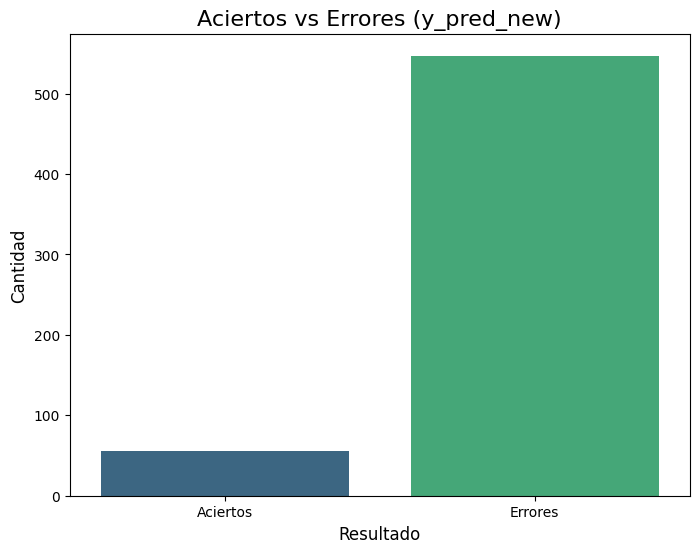

In [58]:
# Calcular el porcentaje de error (desvío) para cada registro
df_results_new = pd.DataFrame({'y_test': y_test, 'y_pred_new': y_pred_new})
df_results_new['error_percentage'] = abs(df_results_new['y_test'] - df_results_new['y_pred_new']) / df_results_new['y_test'] * 100

# Contar los casos acertados y fallidos según el umbral
aciertos_new = (df_results_new['error_percentage'] <= threshold).sum()
fallos_new = (df_results_new['error_percentage'] > threshold).sum()

# Crear un DataFrame para los aciertos y errores
resultados_new = pd.DataFrame({'Resultado': ['Aciertos', 'Errores'], 'Cantidad': [aciertos_new, fallos_new]})

# Graficar los resultados
plt.figure(figsize=(8, 6))
sns.barplot(x='Resultado', y='Cantidad', data=resultados_new, palette='viridis')
plt.title('Aciertos vs Errores (y_pred_new)', fontsize=16)
plt.ylabel('Cantidad', fontsize=12)
plt.xlabel('Resultado', fontsize=12)
plt.show()

In [45]:
# Calcular el porcentaje de error (desvío) para cada registro
df_results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_results['error_percentage'] = abs(df_results['y_test'] - df_results['y_pred']) / df_results['y_test'] * 100

# Definir un umbral de error aceptable (por ejemplo, 10%)
threshold = 10

# Contar los casos acertados y fallidos
aciertos = (df_results['error_percentage'] <= threshold).sum()
fallos = (df_results['error_percentage'] > threshold).sum()

# Mostrar los resultados
print(f"Aciertos: {aciertos}")
print(f"Fallos: {fallos}")

# Mostrar el porcentaje de error para cada registro
print(df_results[['y_test', 'y_pred', 'error_percentage']])

Aciertos: 56
Fallos: 547
             y_test         y_pred  error_percentage
2510   65000.000000  117275.870959         80.424417
900    80000.000000  117275.870959         46.594839
694   180000.000000  118012.558628         34.437467
2224   80000.000000  106277.032595         32.846291
759      244.405407  108338.492614      44227.371368
...             ...            ...               ...
1030  145000.000000  119239.324684         17.765983
2128  180000.000000  102767.408914         42.906995
1291   50000.000000  103472.658822        106.945318
2597  180000.000000  121676.883319         32.401731
1315   50000.000000  110598.354790        121.196710

[603 rows x 3 columns]


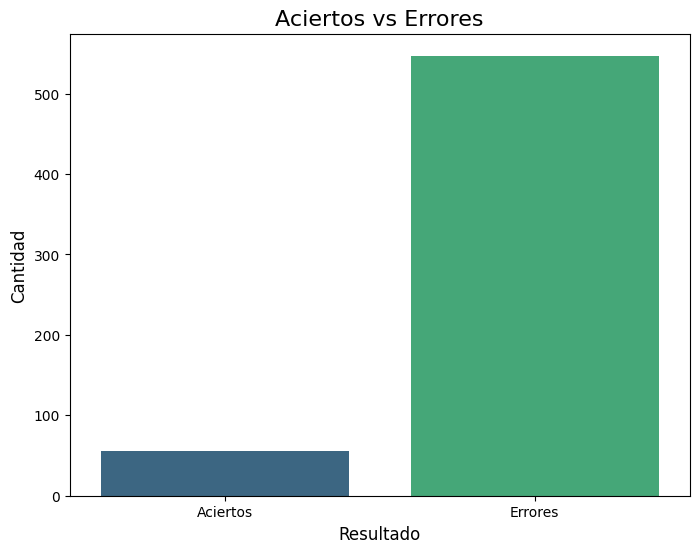

In [46]:
# Crear un DataFrame para los aciertos y errores
resultados = pd.DataFrame({'Resultado': ['Aciertos', 'Errores'], 'Cantidad': [aciertos, fallos]})

# Graficar los resultados
plt.figure(figsize=(8, 6))
sns.barplot(x='Resultado', y='Cantidad', data=resultados, palette='viridis')
plt.title('Aciertos vs Errores', fontsize=16)
plt.ylabel('Cantidad', fontsize=12)
plt.xlabel('Resultado', fontsize=12)
plt.show()

Mejor tamaño de clase: 10000 con varianza total: 125755958.7608597


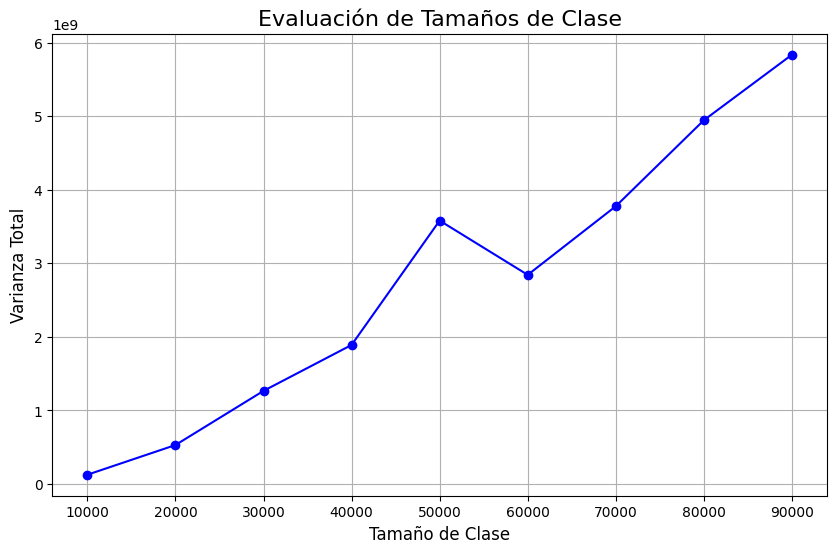

In [59]:
# Función para determinar el mejor tamaño de clase
def determinar_mejor_tamanio_clase(df, columna, tamanios_clase):
    resultados = []
    for tamanio in tamanios_clase:
        # Crear clases basadas en el tamaño de clase
        bins = list(range(int(df[columna].min()), int(df[columna].max()) + tamanio, tamanio))
        df['clase'] = pd.cut(df[columna], bins=bins, include_lowest=True)
        
        # Calcular la varianza dentro de las clases
        varianza_total = df.groupby('clase')[columna].var().sum()
        resultados.append((tamanio, varianza_total))
    
    # Seleccionar el tamaño de clase con la menor varianza
    mejor_tamanio = min(resultados, key=lambda x: x[1])
    return mejor_tamanio, resultados

# Lista de tamaños de clase a evaluar
tamanios_clase = range(10000, 100000, 10000)

# Determinar el mejor tamaño de clase
mejor_tamanio, resultados = determinar_mejor_tamanio_clase(df_all, 'precio', tamanios_clase)

# Mostrar el mejor tamaño de clase
print(f"Mejor tamaño de clase: {mejor_tamanio[0]} con varianza total: {mejor_tamanio[1]}")

# Graficar los resultados
tamanios, varianzas = zip(*resultados)
plt.figure(figsize=(10, 6))
plt.plot(tamanios, varianzas, marker='o', color='blue')
plt.title('Evaluación de Tamaños de Clase', fontsize=16)
plt.xlabel('Tamaño de Clase', fontsize=12)
plt.ylabel('Varianza Total', fontsize=12)
plt.grid(True)
plt.show()

In [60]:
# Agregar una nueva columna 'clase' basada en el precio
df_all['clase'] = (df_all['precio'] // 10000).astype(int)

# Mostrar las primeras filas del DataFrame para verificar el resultado
df_all[['precio', 'clase']].head()

,precio,clase
0,84000.0,8
1,194000.0,19
3,210000.0,21
4,150000.0,15
5,120000.0,12


In [65]:
# Eliminar la columna 'precio'
# df_all = df_all.drop(columns=['precio'])

# Definir características (features) y variable objetivo (target)
X = df_all.drop(['clase', 'publicacion', 'image_blob', 'comentarios'], axis=1)
y = df_all['clase']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear un dataset de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Definir los parámetros para el modelo
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.8,
    'num_leaves': 31,
    'max_depth': 10,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Entrenar el modelo
model = lgb.train(params,
                  train_data,
                  num_boost_round=100,
                  valid_sets=[test_data],
                  callbacks=[lgb.early_stopping(stopping_rounds=10)])  # Usar early_stopping callback

# Predecir el subconjunto de prueba
y_pred = model.predict(X_test)

# Redondear las predicciones al entero más cercano para obtener la clase
y_pred_classes = np.round(y_pred).astype(int)

# Evaluar el modelo
accuracy = np.mean(y_pred_classes == y_test)
print(f"Accuracy: {accuracy}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 11.273115
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 182.973
Accuracy: 0.05140961857379768


In [66]:
# Definir la función objetivo para la optimización
def objective(trial):
    # Definir los hiperparámetros a optimizar
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200)
    }

    # Entrenar el modelo con los hiperparámetros actuales
    model = lgb.train(params, train_data, valid_sets=[test_data])
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular el RMSE
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    return rmse

# Crear un estudio para la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
model = lgb.train(best_params, train_data, num_boost_round=100, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

# Predecir y evaluar el modelo optimizado
y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print(f"RMSE después de la optimización bayesiana: {rmse}")

[I 2025-04-08 19:09:08,106] A new study created in memory with name: no-name-80e3167d-1535-4c13-817f-bdf1e7080682


[LightGBM] [Warning] feature_fraction is set=0.884531459605814, colsample_bytree=0.8257917990377068 will be ignored. Current value: feature_fraction=0.884531459605814
[LightGBM] [Warning] feature_fraction is set=0.884531459605814, colsample_bytree=0.8257917990377068 will be ignored. Current value: feature_fraction=0.884531459605814
[LightGBM] [Warning] feature_fraction is set=0.884531459605814, colsample_bytree=0.8257917990377068 will be ignored. Current value: feature_fraction=0.884531459605814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115


[I 2025-04-08 19:09:08,317] Trial 0 finished with value: 183.07712806217924 and parameters: {'colsample_bytree': 0.8257917990377068, 'num_leaves': 21, 'max_depth': 15, 'subsample': 0.8828042848625146, 'learning_rate': 0.12562165465502145, 'feature_fraction': 0.884531459605814, 'n_estimators': 70}. Best is trial 0 with value: 183.07712806217924.


[LightGBM] [Warning] feature_fraction is set=0.789439299028069, colsample_bytree=0.9483389884348137 will be ignored. Current value: feature_fraction=0.789439299028069
[LightGBM] [Warning] feature_fraction is set=0.789439299028069, colsample_bytree=0.9483389884348137 will be ignored. Current value: feature_fraction=0.789439299028069
[LightGBM] [Warning] feature_fraction is set=0.789439299028069, colsample_bytree=0.9483389884348137 will be ignored. Current value: feature_fraction=0.789439299028069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

[I 2025-04-08 19:09:08,562] Trial 1 finished with value: 183.00302221631094 and parameters: {'colsample_bytree': 0.9483389884348137, 'num_leaves': 34, 'max_depth': 10, 'subsample': 0.6042079015871729, 'learning_rate': 0.12587565476097004, 'feature_fraction': 0.789439299028069, 'n_estimators': 66}. Best is trial 1 with value: 183.00302221631094.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5220705587453428, colsample_bytree=0.9985081916750246 will be ignored. Current value: feature_fraction=0.5220705587453428
[LightGBM] [Warning] feature_fraction is set=0.5220705587453428, colsample_bytree=0.9985081916750246 will be ignored. Current value: feature_fraction=0.5220705587453428
[LightGBM] [Warning] feature_fraction is set=0.522070558745342

[I 2025-04-08 19:09:09,055] Trial 2 finished with value: 182.96612129971933 and parameters: {'colsample_bytree': 0.9985081916750246, 'num_leaves': 30, 'max_depth': 8, 'subsample': 0.6478106209180519, 'learning_rate': 0.1329047367863183, 'feature_fraction': 0.5220705587453428, 'n_estimators': 188}. Best is trial 2 with value: 182.96612129971933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:09,450] Trial 3 finished with value: 183.05066196758392 and parameters: {'colsample_bytree': 0.9106864300098807, 'num_leaves': 20, 'max_depth': 9, 'subsample': 0.7232723428693477, 'learning_rate': 0.15576691201543305, 'feature_fraction': 0.6499518337509458, 'n_estimators': 175}. Best is trial 2 with value: 182.96612129971933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8331675019089005, colsample_bytree=0.8857876101677102 will be ignored. Current value: feature_fraction=0.8331675019089005
[Light

[I 2025-04-08 19:09:09,604] Trial 4 finished with value: 183.0553052308282 and parameters: {'colsample_bytree': 0.8857876101677102, 'num_leaves': 50, 'max_depth': 6, 'subsample': 0.8628365749911118, 'learning_rate': 0.17583422409686303, 'feature_fraction': 0.8331675019089005, 'n_estimators': 68}. Best is trial 2 with value: 182.96612129971933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:10,029] Trial 5 finished with value: 182.99125890012922 and parameters: {'colsample_bytree': 0.6983506961621659, 'num_leaves': 45, 'max_depth': 7, 'subsample': 0.9401616984739309, 'learning_rate': 0.1614014446205278, 'feature_fraction': 0.5921605930667417, 'n_estimators': 148}. Best is trial 2 with value: 182.96612129971933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:10,326] Trial 6 finished with value: 183.10919290537782 and parameters: {'colsample_bytree': 0.9648660117532046, 'num_leaves': 33, 'max_depth': 5, 'subsample': 0.6057155952146538, 'learning_rate': 0.048155939587894006, 'feature_fraction': 0.7351597812986085, 'n_estimators': 173}. Best is trial 2 with value: 182.96612129971933.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:10,920] Trial 7 finished with value: 182.94426868911563 and parameters: {'colsample_bytree': 0.8187838399977712, 'num_leaves': 42, 'max_depth': 10, 'subsample': 0.5546863832271327, 'learning_rate': 0.15194609785121954, 'feature_fraction': 0.7737681840871397, 'n_estimators': 191}. Best is trial 7 with value: 182.94426868911563.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:11,662] Trial 8 finished with value: 182.85828179188147 and parameters: {'colsample_bytree': 0.9384843204761398, 'num_leaves': 40, 'max_depth': 13, 'subsample': 0.5028055055495454, 'learning_rate': 0.1852806659190616, 'feature_fraction': 0.6394968854397507, 'n_estimators': 191}. Best is trial 8 with value: 182.85828179188147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7601803180883012, colsample_bytree=0.9926736165489922 will be ignored. Current value: feature_fraction=0.7601803180883012
[LightGBM] [Warning] feature_fraction is set=0.7601803180883012, colsample_bytree=0.9926736165489922 will be ignored. Current value: feature_fraction=0.7601803180883012
[LightGBM] [Warning] feature_fraction is set=0.7601803180883012, colsample_bytree=0.9926736165489922 will be ignored. Current value: feature_fraction=0.7601803180883012
[LightGBM] [Info] Auto-choosing row-wise mu

[I 2025-04-08 19:09:11,851] Trial 9 finished with value: 183.10258622734722 and parameters: {'colsample_bytree': 0.9926736165489922, 'num_leaves': 32, 'max_depth': 7, 'subsample': 0.642636770527006, 'learning_rate': 0.14330874496831772, 'feature_fraction': 0.7601803180883012, 'n_estimators': 83}. Best is trial 8 with value: 182.85828179188147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6532114643046668, colsample_bytree=0.5194888449967457 will be ignored. Current value: feature_fraction=0.6532114643046668
[Light

[I 2025-04-08 19:09:12,327] Trial 10 finished with value: 182.99831568651507 and parameters: {'colsample_bytree': 0.5194888449967457, 'num_leaves': 39, 'max_depth': 13, 'subsample': 0.5247846247584939, 'learning_rate': 0.07360263321840513, 'feature_fraction': 0.6532114643046668, 'n_estimators': 113}. Best is trial 8 with value: 182.85828179188147.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9451215663835351, colsample_bytree=0.7391644324327721

[I 2025-04-08 19:09:13,131] Trial 11 finished with value: 182.83275269614782 and parameters: {'colsample_bytree': 0.7391644324327721, 'num_leaves': 41, 'max_depth': 12, 'subsample': 0.5060962283805732, 'learning_rate': 0.18510529031526946, 'feature_fraction': 0.9451215663835351, 'n_estimators': 199}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:13,682] Trial 12 finished with value: 183.01763429536376 and parameters: {'colsample_bytree': 0.683901700764037, 'num_leaves': 39, 'max_depth': 12, 'subsample': 0.502506137346027, 'learning_rate': 0.19705213520838283, 'feature_fraction': 0.9898284558649295, 'n_estimators': 145}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9748251022385777, colsample_bytree=0.6185186599565795 will be ignored. Current value: feature_fraction=0.9748251022385777
[LightGBM] [Warning] feature_fraction is set=0.9748251022385777, colsample_bytree=0.6185186599565795 will be ignored. Current value: feature_fraction=0.9748251022385777
[LightGBM] [Warning] feature_fraction is set=0.9748251022385777, colsample_bytree=0.6185186599565795 will be ignored. Current value: feature_fraction=0.9748251022385777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `f

[I 2025-04-08 19:09:14,564] Trial 13 finished with value: 183.06143896663232 and parameters: {'colsample_bytree': 0.6185186599565795, 'num_leaves': 46, 'max_depth': 13, 'subsample': 0.7494287327373982, 'learning_rate': 0.19864988934292394, 'feature_fraction': 0.9748251022385777, 'n_estimators': 199}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:15,042] Trial 14 finished with value: 183.03967033063626 and parameters: {'colsample_bytree': 0.7871916867390303, 'num_leaves': 26, 'max_depth': 15, 'subsample': 0.6815934717535574, 'learning_rate': 0.09017533892112456, 'feature_fraction': 0.8995200090964397, 'n_estimators': 151}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6863832497965342, colsample_bytree=0.72694772323218 will be ignored. Current value: feature_fraction=0.6863832497965342
[LightGBM] [Warning] feature_fraction is set=0.6863832497965342, colsample_bytree=0.72694772323218 will be ignored. Current value: feature_fraction=0.6863832497965342
[LightGBM] [Warning] feature_fraction is set=0.6863832497965342, colsample_bytree=0.72694772323218 will be ignored. Current value: feature_fraction=0.6863832497965342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 

[I 2025-04-08 19:09:15,477] Trial 15 finished with value: 183.04012809885913 and parameters: {'colsample_bytree': 0.72694772323218, 'num_leaves': 38, 'max_depth': 12, 'subsample': 0.5680836198255744, 'learning_rate': 0.015297794220950414, 'feature_fraction': 0.6863832497965342, 'n_estimators': 102}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] feature_fraction is set=0.5425333627911184, colsample_bytree=0.619392966701366 will be ignored. Current value: feature_fraction=0.5425333627911184
[LightGBM] [Warning] feature_fraction is set=0.5425333627911184, colsample_bytree=0.619392966701366 will be ignored. Current value: feature_fraction=0.5425333627911184
[LightGBM] [Warning] feature_fraction is set=0.5425333627911184, colsample_bytree=0.619392966701366 will be ignored. Current value: feature_fraction=0.5425333627911184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[I 2025-04-08 19:09:16,162] Trial 16 finished with value: 182.83975701885961 and parameters: {'colsample_bytree': 0.619392966701366, 'num_leaves': 43, 'max_depth': 12, 'subsample': 0.8024419706901592, 'learning_rate': 0.18182048748818683, 'feature_fraction': 0.5425333627911184, 'n_estimators': 160}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feat

[I 2025-04-08 19:09:16,863] Trial 17 finished with value: 182.95142609509546 and parameters: {'colsample_bytree': 0.615064484381795, 'num_leaves': 50, 'max_depth': 11, 'subsample': 0.8259712650165859, 'learning_rate': 0.10825178187530954, 'feature_fraction': 0.524978530161216, 'n_estimators': 166}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:17,481] Trial 18 finished with value: 182.88835523328035 and parameters: {'colsample_bytree': 0.5020160986946176, 'num_leaves': 44, 'max_depth': 14, 'subsample': 0.8097064245846508, 'learning_rate': 0.1720622540178663, 'feature_fraction': 0.9127279596334175, 'n_estimators': 135}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:18,087] Trial 19 finished with value: 182.99610279547358 and parameters: {'colsample_bytree': 0.6145875035975156, 'num_leaves': 47, 'max_depth': 11, 'subsample': 0.9967705463843328, 'learning_rate': 0.10600203648333673, 'feature_fraction': 0.5787222986290335, 'n_estimators': 165}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:18,496] Trial 20 finished with value: 182.97213187238052 and parameters: {'colsample_bytree': 0.5608839453600322, 'num_leaves': 37, 'max_depth': 11, 'subsample': 0.7770180875272529, 'learning_rate': 0.17929118973530245, 'feature_fraction': 0.8523966913678898, 'n_estimators': 124}. Best is trial 11 with value: 182.83275269614782.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:19,313] Trial 21 finished with value: 182.82748219651424 and parameters: {'colsample_bytree': 0.7539748767866922, 'num_leaves': 43, 'max_depth': 13, 'subsample': 0.7010523606833002, 'learning_rate': 0.1875168866297094, 'feature_fraction': 0.5828762424429377, 'n_estimators': 184}. Best is trial 21 with value: 182.82748219651424.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:20,051] Trial 22 finished with value: 182.89913118352214 and parameters: {'colsample_bytree': 0.7681710230863673, 'num_leaves': 42, 'max_depth': 14, 'subsample': 0.719883457555176, 'learning_rate': 0.1991073214434182, 'feature_fraction': 0.5776466598202776, 'n_estimators': 179}. Best is trial 21 with value: 182.82748219651424.


[LightGBM] [Warning] feature_fraction is set=0.5071941881862835, colsample_bytree=0.6682761688472849 will be ignored. Current value: feature_fraction=0.5071941881862835
[LightGBM] [Warning] feature_fraction is set=0.5071941881862835, colsample_bytree=0.6682761688472849 will be ignored. Current value: feature_fraction=0.5071941881862835
[LightGBM] [Warning] feature_fraction is set=0.5071941881862835, colsample_bytree=0.6682761688472849 will be ignored. Current value: feature_fraction=0.5071941881862835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2025-04-08 19:09:20,653] Trial 23 finished with value: 182.91361954298097 and parameters: {'colsample_bytree': 0.6682761688472849, 'num_leaves': 43, 'max_depth': 12, 'subsample': 0.7926927262006565, 'learning_rate': 0.1720074322409478, 'feature_fraction': 0.5071941881862835, 'n_estimators': 161}. Best is trial 21 with value: 182.82748219651424.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:21,447] Trial 24 finished with value: 182.7829073504069 and parameters: {'colsample_bytree': 0.730641511601155, 'num_leaves': 36, 'max_depth': 14, 'subsample': 0.8632300946544722, 'learning_rate': 0.14310327149171292, 'feature_fraction': 0.7106695289863281, 'n_estimators': 199}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7015509128172844, colsample_bytree=0.7292216560000869 will be ignored. Current value: feature_fraction=0.7015509128172844
[LightGBM] [Warning] feature_fraction is set=0.7015509128172844, colsample_bytree=0.7292216560000869 will be ignored. Current value: feature_fraction=0.7015509128172844
[LightGBM] [Warning] feature_fraction is set=0.7015509128172844, colsample_bytree=0.7292216560000869 will be ignored. Current value: feature_fraction=0.7015509128172844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGB

[I 2025-04-08 19:09:22,170] Trial 25 finished with value: 182.84681053423083 and parameters: {'colsample_bytree': 0.7292216560000869, 'num_leaves': 36, 'max_depth': 14, 'subsample': 0.9306254159205529, 'learning_rate': 0.13779057489992808, 'feature_fraction': 0.7015509128172844, 'n_estimators': 197}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:22,834] Trial 26 finished with value: 182.93123974872344 and parameters: {'colsample_bytree': 0.851811862585212, 'num_leaves': 30, 'max_depth': 15, 'subsample': 0.8631764440425503, 'learning_rate': 0.161953984755569, 'feature_fraction': 0.9400680282888483, 'n_estimators': 182}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] feature_fraction is set=0.7992062234331986, colsample_bytree=0.7893019063490757 will be ignored. Current value: feature_fraction=0.7992062234331986
[LightGBM] [Warning] feature_fraction is set=0.7992062234331986, colsample_bytree=0.7893019063490757 will be ignored. Current value: feature_fraction=0.7992062234331986
[LightGBM] [Warning] feature_fraction is set=0.7992062234331986, colsample_bytree=0.7893019063490757 will be ignored. Current value: feature_fraction=0.7992062234331986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2025-04-08 19:09:23,513] Trial 27 finished with value: 182.88735590396783 and parameters: {'colsample_bytree': 0.7893019063490757, 'num_leaves': 48, 'max_depth': 13, 'subsample': 0.6945714202171166, 'learning_rate': 0.14793942902081186, 'feature_fraction': 0.7992062234331986, 'n_estimators': 183}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7301939660319015, colsample_bytree=0.7419020757566095

[I 2025-04-08 19:09:24,337] Trial 28 finished with value: 182.83489716770012 and parameters: {'colsample_bytree': 0.7419020757566095, 'num_leaves': 41, 'max_depth': 14, 'subsample': 0.913912839070381, 'learning_rate': 0.18957767217851937, 'feature_fraction': 0.7301939660319015, 'n_estimators': 200}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6169698440828428, colsample_bytree=0.8329331762368948 will be ignored. Current value: feature_fraction=0.6169698440828428
[LightGBM] [Warning] feature_fraction is set=0.6169698440828428, colsample_bytree=0.8329331762368948 will be ignored. Current value: feature_fraction=0.6169698440828428
[LightGBM] [Warning] feature_fraction is set=0.616969844082842

[I 2025-04-08 19:09:25,049] Trial 29 finished with value: 182.97946804288551 and parameters: {'colsample_bytree': 0.8329331762368948, 'num_leaves': 35, 'max_depth': 15, 'subsample': 0.9824978052567843, 'learning_rate': 0.12326935482319257, 'feature_fraction': 0.6169698440828428, 'n_estimators': 173}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6935460620589623, colsample_bytree=0.7040857211182692 will be ignored. Current value: feature_fraction=0.6935460620589623
[LightGBM] [Warning] feature_fraction is set=0.6935460620589623, colsample_bytree=0.7040857211182692 will be ignored. Current value: feature_fraction=0.6935460620589623
[LightGBM] [Warning] feature_fraction is set=0.6935460620589623, colsample_bytree=0.7040857211182692 will be ignored. Current value: feature_fraction=0.6935460620589623
[LightGBM] [Info] Auto-choosing col-wise mu

[I 2025-04-08 19:09:25,316] Trial 30 finished with value: 183.04877545144902 and parameters: {'colsample_bytree': 0.7040857211182692, 'num_leaves': 25, 'max_depth': 9, 'subsample': 0.844398854557038, 'learning_rate': 0.11753462341956564, 'feature_fraction': 0.6935460620589623, 'n_estimators': 84}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:26,070] Trial 31 finished with value: 182.89252966067838 and parameters: {'colsample_bytree': 0.7520606860052748, 'num_leaves': 41, 'max_depth': 14, 'subsample': 0.9051523604476719, 'learning_rate': 0.19102645258320564, 'feature_fraction': 0.8381551698169817, 'n_estimators': 200}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:26,759] Trial 32 finished with value: 182.79677904696103 and parameters: {'colsample_bytree': 0.6540427935288058, 'num_leaves': 37, 'max_depth': 14, 'subsample': 0.9080727309858789, 'learning_rate': 0.16164538544710566, 'feature_fraction': 0.7246192556779747, 'n_estimators': 192}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:27,506] Trial 33 finished with value: 182.83431743636126 and parameters: {'colsample_bytree': 0.6548763098466354, 'num_leaves': 37, 'max_depth': 13, 'subsample': 0.8875208212905095, 'learning_rate': 0.16290252170814368, 'feature_fraction': 0.8044521033080528, 'n_estimators': 188}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:28,173] Trial 34 finished with value: 182.8127265195484 and parameters: {'colsample_bytree': 0.6575714334012784, 'num_leaves': 31, 'max_depth': 14, 'subsample': 0.9388301020397392, 'learning_rate': 0.13628778980361325, 'feature_fraction': 0.7149938065090368, 'n_estimators': 189}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7226870140635114, colsample_bytree=0.5764850882988637

[I 2025-04-08 19:09:28,812] Trial 35 finished with value: 182.88359220329795 and parameters: {'colsample_bytree': 0.5764850882988637, 'num_leaves': 30, 'max_depth': 15, 'subsample': 0.9732392370671473, 'learning_rate': 0.12795276326108532, 'feature_fraction': 0.7226870140635114, 'n_estimators': 184}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6817451591919496, colsample_bytree=0.6658530298868637 will be ignored. Current value: feature_fraction=0.6817451591919496
[LightGBM] [Warning] feature_fraction is set=0.6817451591919496, colsample_bytree=0.6658530298868637 will be ignored. Current value: feature_fraction=0.6817451591919496
[LightGBM] [Warning] feature_fraction is set=0.6817451591919496, colsample_bytree=0.6658530298868637 will be ignored. Current value: feature_fraction=0.6817451591919496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-08 19:09:29,401] Trial 36 finished with value: 182.92381235836385 and parameters: {'colsample_bytree': 0.6658530298868637, 'num_leaves': 27, 'max_depth': 14, 'subsample': 0.9673048354838688, 'learning_rate': 0.13790647773205547, 'feature_fraction': 0.6817451591919496, 'n_estimators': 172}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6223317997817033, colsample_bytree=0.7064700703793234 will be ignored. Current value: feature_fraction=0.6223317997817033
[LightGBM] [Warning] feature_fraction is set=0.6223317997817033, colsample_bytree=0.7064700703793234 will be ignored. Current value: feature_fraction=0.6223317997817033
[LightGBM] [Warning] feature_fraction is set=0.6223317997817033, colsample_bytree=0.7064700703793234 will be ignored. Current value: feature_fraction=0.6223317997817033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGB

[I 2025-04-08 19:09:29,997] Trial 37 finished with value: 182.95587897952117 and parameters: {'colsample_bytree': 0.7064700703793234, 'num_leaves': 32, 'max_depth': 15, 'subsample': 0.9463308811776772, 'learning_rate': 0.09131081931939858, 'feature_fraction': 0.6223317997817033, 'n_estimators': 153}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6649393389144882, colsample_bytree=0.648224313597822 will be ignored. Current value: feature_fraction=0.6649393389144882
[LightGBM] [Warning] feature_fraction is set=0.6649393389144882, colsample_bytree=0.648224313597822 will be ignored. Current value: feature_fraction=0.6649393389144882
[LightGBM] [Warning] feature_fraction is set=0.6649393389144882, colsample_bytree=0.648224313597822 will be ignored. Current value: feature_fraction=0.6649393389144882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[Lig

[I 2025-04-08 19:09:30,546] Trial 38 finished with value: 182.98056033359472 and parameters: {'colsample_bytree': 0.648224313597822, 'num_leaves': 22, 'max_depth': 13, 'subsample': 0.8692482152145796, 'learning_rate': 0.15469908160654144, 'feature_fraction': 0.6649393389144882, 'n_estimators': 189}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] feature_fraction is set=0.7672064759108085, colsample_bytree=0.5897025982277624 will be ignored. Current value: feature_fraction=0.7672064759108085
[LightGBM] [Warning] feature_fraction is set=0.7672064759108085, colsample_bytree=0.5897025982277624 will be ignored. Current value: feature_fraction=0.7672064759108085
[LightGBM] [Warning] feature_fraction is set=0.7672064759108085, colsample_bytree=0.5897025982277624 will be ignored. Current value: feature_fraction=0.7672064759108085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-08 19:09:31,225] Trial 39 finished with value: 182.79958998081344 and parameters: {'colsample_bytree': 0.5897025982277624, 'num_leaves': 34, 'max_depth': 14, 'subsample': 0.893301083178812, 'learning_rate': 0.1669652143707821, 'feature_fraction': 0.7672064759108085, 'n_estimators': 175}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7596742394068412, colsample_bytree=0.5743015783118648 will be ignored. Current value: feature_fraction=0.7596742394068412
[LightGBM] [Warning] feature_fraction is set=0.7596742394068412, colsample_bytree=0.5743015783118648 will be ignored. Current value: feature_fraction=0.7596742394068412
[LightGBM] [Warning] feature_fraction is set=0.7596742394068412, colsample_bytree=0.5743015783118648 will be ignored. Current value: feature_fraction=0.7596742394068412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used feat

[I 2025-04-08 19:09:31,647] Trial 40 finished with value: 182.96535024284734 and parameters: {'colsample_bytree': 0.5743015783118648, 'num_leaves': 34, 'max_depth': 10, 'subsample': 0.8919707842338471, 'learning_rate': 0.1659231265991606, 'feature_fraction': 0.7596742394068412, 'n_estimators': 137}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7834223134985205, colsample_bytree=0.6362570069928084 will be ignored. Current value: feature_fraction=0.7834223134985205
[LightGBM] [Warning] feature_fraction is set=0.7834223134985205, colsample_bytree

[I 2025-04-08 19:09:32,288] Trial 41 finished with value: 182.9519693750507 and parameters: {'colsample_bytree': 0.6362570069928084, 'num_leaves': 32, 'max_depth': 14, 'subsample': 0.9434542545711294, 'learning_rate': 0.14736907653062897, 'feature_fraction': 0.7834223134985205, 'n_estimators': 178}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7119600170206704, colsample_bytree=0.5463658947583486 will be ignored. Current value: feature_fraction=0.7119600170206704
[LightGBM] [Warning] feature_fraction is set=0.7119600170206704, colsample_bytree=0.5463658947583486 will be ignored. Current value: feature_fraction=0.7119600170206704
[LightGBM] [Warning] feature_fraction is set=0.7119600170206704, colsample_bytree=0.5463658947583486 will be ignored. Current value: feature_fraction=0.7119600170206704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, yo

[I 2025-04-08 19:09:32,886] Trial 42 finished with value: 182.80480622633874 and parameters: {'colsample_bytree': 0.5463658947583486, 'num_leaves': 28, 'max_depth': 15, 'subsample': 0.832681587468835, 'learning_rate': 0.16998500442689393, 'feature_fraction': 0.7119600170206704, 'n_estimators': 192}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7128605961812681, colsample_bytree=0.5360408718152578 will be ignored. Current value: feature_fraction=0.7128605961812681
[LightGBM] [Warning] feature_fraction is set=0.7128605961812681, colsample_bytree=0.5360408718152578 will be ignored. Current value: feature_fraction=0.7128605961812681
[LightGBM] [Warning] feature_fraction is set=0.7128605961812681, colsample_bytree=0.5360408718152578 will be ignored. Current value: feature_fraction=0.7128605961812681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used feat

[I 2025-04-08 19:09:33,519] Trial 43 finished with value: 182.89998787824248 and parameters: {'colsample_bytree': 0.5360408718152578, 'num_leaves': 29, 'max_depth': 15, 'subsample': 0.8367938459718433, 'learning_rate': 0.15449351329774025, 'feature_fraction': 0.7128605961812681, 'n_estimators': 193}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] feature_fraction is set=0.7554887848218511, colsample_bytree=0.5921701540432078 will be ignored. Current value: feature_fraction=0.7554887848218511
[LightGBM] [Warning] feature_fraction is set=0.7554887848218511, colsample_bytree=0.5921701540432078 will be ignored. Current value: feature_fraction=0.7554887848218511
[LightGBM] [Warning] feature_fraction is set=0.7554887848218511, colsample_bytree=0.5921701540432078 will be ignored. Current value: feature_fraction=0.7554887848218511
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2025-04-08 19:09:34,155] Trial 44 finished with value: 182.8848105586828 and parameters: {'colsample_bytree': 0.5921701540432078, 'num_leaves': 34, 'max_depth': 15, 'subsample': 0.9189879988297112, 'learning_rate': 0.13617384686105527, 'feature_fraction': 0.7554887848218511, 'n_estimators': 169}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] feature_fraction is set=0.7375297294227973, colsample_bytree=0.5419442776330359 will be ignored. Current value: feature_fraction=0.7375297294227973
[LightGBM] [Warning] feature_fraction is set=0.7375297294227973, colsample_bytree=0.5419442776330359 will be ignored. Current value: feature_fraction=0.7375297294227973
[LightGBM] [Warning] feature_fraction is set=0.7375297294227973, colsample_bytree=0.5419442776330359 will be ignored. Current value: feature_fraction=0.7375297294227973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-08 19:09:34,828] Trial 45 finished with value: 182.9199481680184 and parameters: {'colsample_bytree': 0.5419442776330359, 'num_leaves': 28, 'max_depth': 14, 'subsample': 0.8686483579452137, 'learning_rate': 0.11733617652633264, 'feature_fraction': 0.7375297294227973, 'n_estimators': 190}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6681227432679484, colsample_bytree=0.5891795463954436

[I 2025-04-08 19:09:35,310] Trial 46 finished with value: 182.8546564182454 and parameters: {'colsample_bytree': 0.5891795463954436, 'num_leaves': 24, 'max_depth': 14, 'subsample': 0.7608756212694401, 'learning_rate': 0.16873895169235026, 'feature_fraction': 0.6681227432679484, 'n_estimators': 176}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] feature_fraction is set=0.8192110135394877, colsample_bytree=0.6885145289515952 will be ignored. Current value: feature_fraction=0.8192110135394877
[LightGBM] [Warning] feature_fraction is set=0.8192110135394877, colsample_bytree=0.6885145289515952 will be ignored. Current value: feature_fraction=0.8192110135394877
[LightGBM] [Warning] feature_fraction is set=0.8192110135394877, colsample_bytree=0.6885145289515952 will be ignored. Current value: feature_fraction=0.8192110135394877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 1406, number of used features: 46
[LightGBM] [Info] Start training from score 11.273115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-04-08 19:09:35,855] Trial 47 finished with value: 182.997965988291 and parameters: {'colsample_bytree': 0.6885145289515952, 'num_leaves': 33, 'max_depth': 8, 'subsample': 0.846862934638635, 'learning_rate': 0.1457232641851972, 'feature_fraction': 0.8192110135394877, 'n_estimators': 191}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:36,111] Trial 48 finished with value: 183.0822960804705 and parameters: {'colsample_bytree': 0.551314151238557, 'num_leaves': 31, 'max_depth': 5, 'subsample': 0.9555062228104803, 'learning_rate': 0.1575372367327051, 'feature_fraction': 0.774525114570263, 'n_estimators': 157}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-08 19:09:36,766] Trial 49 finished with value: 182.9343292022514 and parameters: {'colsample_bytree': 0.6324219506522868, 'num_leaves': 36, 'max_depth': 13, 'subsample': 0.9042843105659369, 'learning_rate': 0.17657566990051973, 'feature_fraction': 0.8653949324131035, 'n_estimators': 195}. Best is trial 24 with value: 182.7829073504069.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [68]:
# Entrenar el modelo con los nuevos parámetros
model_new_params = lgb.train(best_params,
                             train_data_new,
                             num_boost_round=100,
                             valid_sets=[test_data_new],
                             callbacks=[lgb.early_stopping(stopping_rounds=10)])  # Usar early_stopping callback

# Predecir en el conjunto de prueba
y_pred_new_params = model_new_params.predict(X_test)

# Redondear las predicciones al entero más cercano para obtener la clase
y_pred_new_classes = np.round(y_pred_new_params).astype(int)

# Calcular el accuracy
accuracy_new = np.mean(y_pred_new_classes == y_test)
print(f"Accuracy con los nuevos parámetros: {accuracy_new}")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7106695289863281, colsample_bytree=0.730641511601155 will be ignored. Current value: feature_fraction=0.7106695289863281
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.9967880717646387 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7106695289863281, colsample_bytree=0.730641511601155 will be ignored. Current value: feature_fraction=0.7106695289863281
[LightGBM] [Warning] feature_fraction is set=0.7106695289863281, colsample_bytree=0.730641511601155 will be ignored. Current value: feature_fraction=0.7106695289863281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise